In [1]:
cd /content/drive/My Drive/Colab Notebooks/Eval_brain_mri

/content/drive/My Drive/Colab Notebooks/Eval_brain_mri


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import torch

In [3]:
def show_image(img):
  plt.imshow(img)
  plt.show()

In [4]:
from utils.dataloader import make_datapath_list, DataTransform, BrainDataset
rootpath = os.path.abspath("")
makepath = make_datapath_list(rootpath)
test_img_list, test_anno_list = makepath.get_list("test")

In [5]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes = 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
state_dict = torch.load('weights/pspnet50_15.pth', map_location={"cuda:0": "cpu"})
net.load_state_dict(state_dict)
net.to(device)

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [6]:
class PSPNet_make_mask():
  """
  function: This function can make the inference mask of PSPnet model.
  """

  def __init__(self, img_path_list, anno_path_list, net, input_size, device):
    """
    input
    -------------------------------------
    img_path_list: List of image paths to infer
    anno_path_list: List of anno paths
    net: Pretrained PSPNet model
    input_size: The size of the image to enter into the model
    """
    self.img_path_list = img_path_list
    self.anno_path_list = anno_path_list
    self.net = net.to(device)
    self.device = device
    self.transform = DataTransform(input_size=input_size)
  
  def make_mask(self, idx):
    """
    input
    -------------------------------------
    idx: Index number of the path
    -------------------------------------

    output
    -------------------------------------
    inference_mask: Inference result mask
    annotaion_mask: Grand truth mask
    -------------------------------------
    """
    image_file_path = self.img_path_list[idx]
    anno_file_path = self.anno_path_list[idx]

    img = Image.open(image_file_path)
    img_width, img_height = img.size

    anno_class_img = Image.open(anno_file_path) 
    anno_class_img = anno_class_img.convert('P')
    annotation_mask = anno_class_img

    img, anno_class_img = self.transform("val", img, anno_class_img)

    self.net.eval()
    x = img.unsqueeze(0)
    x = x.to(self.device, dtype=torch.float)
    outputs = self.net(x)
    y = outputs[0]
    device2 = torch.device('cpu')
    y = y.to(device2)
    y = y[0].detach().numpy()
    y = np.argmax(y, axis=0)

    annotation_mask = np.array(annotation_mask)
    annotation_mask = np.where(annotation_mask==0, 0, 1)
    inference_mask = cv2.resize(np.uint8(y), (img_width, img_height))
    inference_mask = np.where(inference_mask==0, 0, 1)

    return inference_mask, annotation_mask

  def IoU(self, idx, return_mask=False):

    pred_mask, truth_mask = self.make_mask(idx)    
    tp = np.count_nonzero((truth_mask ==1) & (pred_mask == 1))
    tn = np.count_nonzero((truth_mask ==0) & (pred_mask == 0))
    fn = np.count_nonzero((truth_mask ==1) & (pred_mask == 0))
    fp = np.count_nonzero((truth_mask ==0) & (pred_mask == 1))

    if (tp + fp + fn) == 0:
      iou = 100
      detect = 'All_TN'
    elif tp == 0 and fp == 0:
      iou = tp/(tp + fp + fn)*100
      detect = 'No_detect'
    elif tp == 0 and fn == 0:
      iou = tp/(tp + fp + fn)*100
      detect = 'Mis_detect'
    else:
      iou = tp/(tp + fp + fn)*100
      detect = 'Detect'

    if return_mask:
      return pred_mask, truth_mask, iou, detect
    else:
      return iou, detect

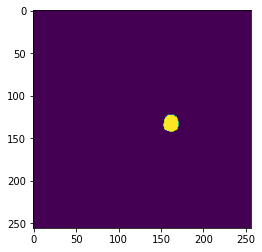

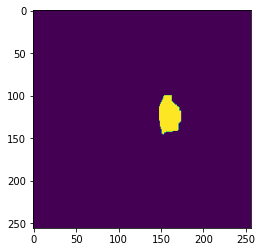

In [7]:
pspnet_mask = PSPNet_make_mask(test_img_list, test_anno_list, net, 475, device)
inference_mask, annotation_mask = pspnet_mask.make_mask(20)
show_image(inference_mask)
show_image(annotation_mask)

32.62331838565022 Detect


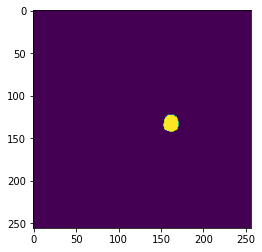

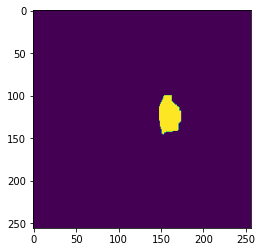

In [8]:
#from utils.pspnet_iou import PSPNet_make_mask
pspnet_mask = PSPNet_make_mask(test_img_list, test_anno_list, net, 475, device)
inference_mask, annotation_mask, iou, detect = pspnet_mask.IoU(20, return_mask=True)
print(iou, detect)
show_image(inference_mask)
show_image(annotation_mask)

In [9]:
pspnet_mask = PSPNet_make_mask(test_img_list, test_anno_list, net, 475, device)
index = [] 
result_iou = []
columns = ["iou", 'detect']
count_no_detect = 0
count_mis_detect = 0
sum_iou = 0
count = 0
for i, img_path in enumerate(test_img_list):
  add_path = img_path.split('/')[-1]
  iou, detect = pspnet_mask.IoU(i)
  if detect == "Detect":
    sum_iou += iou
    count += 1
  elif detect == "No_detect":
    count_no_detect += 1
  elif detect == "Mis_detect":
    count_mis_detect += 1

  iou = str(iou)
  index.append(add_path)
  result_iou.append([iou, detect])

  print('Number:', i, 'IoU:', iou, "detect:", detect)
print('Average IoU:', sum_iou/count)
index.append("avg iou")
result_iou.append([str(sum_iou/count), ''])

Number: 0 IoU: 100 detect: All_TN
Number: 1 IoU: 100 detect: All_TN
Number: 2 IoU: 100 detect: All_TN
Number: 3 IoU: 100 detect: All_TN
Number: 4 IoU: 100 detect: All_TN
Number: 5 IoU: 100 detect: All_TN
Number: 6 IoU: 100 detect: All_TN
Number: 7 IoU: 100 detect: All_TN
Number: 8 IoU: 100 detect: All_TN
Number: 9 IoU: 100 detect: All_TN
Number: 10 IoU: 100 detect: All_TN
Number: 11 IoU: 100 detect: All_TN
Number: 12 IoU: 100 detect: All_TN
Number: 13 IoU: 100 detect: All_TN
Number: 14 IoU: 100 detect: All_TN
Number: 15 IoU: 0.0 detect: No_detect
Number: 16 IoU: 0.0 detect: No_detect
Number: 17 IoU: 0.0 detect: No_detect
Number: 18 IoU: 0.0 detect: No_detect
Number: 19 IoU: 1.762632197414806 detect: Detect
Number: 20 IoU: 32.62331838565022 detect: Detect
Number: 21 IoU: 40.73006724303554 detect: Detect
Number: 22 IoU: 100 detect: All_TN
Number: 23 IoU: 0.0 detect: No_detect
Number: 24 IoU: 41.60206718346253 detect: Detect
Number: 25 IoU: 17.24470134874759 detect: Detect
Number: 26 IoU:

In [12]:
import pandas as pd
df = pd.DataFrame(result_iou)
df.columns = columns
df.index = index
df.to_csv("pspnet_result_per_image.csv")

In [13]:
result_index = ["avg_iou", "No_detect", "Mis_detect", "Recall", "Precision"]
avg_iou = (sum_iou/count)

recall = count / (count + count_no_detect)
precision = count / (count + count_mis_detect)
result = [avg_iou, count_no_detect, count_mis_detect, recall, precision]
df = pd.DataFrame(result)
df.index = result_index
df.to_csv("pspnet_result.csv")